#### Load Dataset

In [1]:
# Import required modules
import numpy as np
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from pprint import pprint
from IPython.display import display
import seaborn as sns; sns.set(font_scale=1.2)

import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Load the data into variable 'df' from pickled object
from funcs import load_df
df = load_df()

# Get an overview of the raw data
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 19 columns):
PatientId         110527 non-null int64
AppointmentID     110527 non-null int64
Gender            110527 non-null category
ScheduledDay      110527 non-null datetime64[ns]
ScheduledTime     110527 non-null object
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null category
Scholarship       110527 non-null int64
Hypertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handicap          110527 non-null int64
SMSReceived       110527 non-null int64
NoShow            110527 non-null bool
DaysInAdvance     110527 non-null int64
ScheduledDOW      110527 non-null category
AppointmentDOW    110527 non-null category
age_range         106988 non-null category
dtypes: bool(1), category(5), datetime64[ns](2), int64(10), object(1)
memory usage: 11.2+ MB


#### Clean Dataset

In [2]:
# Convert categorical variables to the correct datatype
categ_features = ['Gender', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes',
                  'Alcoholism', 'Handcap', 'SMS_received', 'No-show'
                  ]
df[categ_features] = df[categ_features].astype('category')

# Pull-out the scheduled time of day as a new variable (ScheduledTime) and re-insert into df
df.ScheduledDay, ScheduledTime = df.ScheduledDay.str.split('T', 1).str
df.insert(loc=4, column='ScheduledTime', value=ScheduledTime)

# Convert date-time variables to the correct type using the C-style fmt codes
df.ScheduledDay = pd.to_datetime(df.ScheduledDay, format="%Y-%m-%d")
df.ScheduledTime = pd.to_datetime(df.ScheduledTime, format="%H:%M:%SZ").dt.time
df.AppointmentDay = pd.to_datetime(df.AppointmentDay, format="%Y-%m-%dT%H:%M:%SZ")

# Cast PatientId as int
df.PatientId = df.PatientId.astype(np.int64)

# Rename incorrect column names.
df = df.rename(columns={'Hipertension': 'Hypertension', 'Handcap': 'Handicap', 'SMS_received': 'SMSReceived', 'No-show': 'NoShow'})

# Impute the values of sub zero age observations
df.Age=df.Age.replace(-1, int(df.Age.median()))

# Create a column showing days in advance
df['DaysInAdvance']=(df['AppointmentDay']-df['ScheduledDay']).dt.days

# Run through the data to ensure no appointments that are scheduled after the appointment(which would be impossible).
# If true, scheduled day with the appointment day is assumed as the a same day as the appointment, then recalculate advance field
df['ScheduledDay'] = np.where(df['ScheduledDay']>df['AppointmentDay'], df['AppointmentDay'], df['ScheduledDay'])
df['DaysInAdvance']=(df['AppointmentDay']-df['ScheduledDay']).dt.days

# Create a day of week variable for both the scheduled day and the appointment day which will allows to examining
#  any potential trends related to the day of the week and appointment no-show
df['ScheduledDOW'] = df['ScheduledDay'].dt.weekday_name
df['AppointmentDOW'] = df['AppointmentDay'].dt.weekday_name



#### Create new variables

In [3]:
#new variables
df['age_range'] = pd.cut(df.Age,[0,16,65,1e6],3,labels=['child','adult','senior']) 
df = df.replace({'NoShow': {'Yes': 1, 'No': 0}})

df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 19 columns):
PatientId         110527 non-null int64
AppointmentID     110527 non-null int64
Gender            110527 non-null category
ScheduledDay      110527 non-null datetime64[ns]
ScheduledTime     110527 non-null object
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null category
Scholarship       110527 non-null category
Hypertension      110527 non-null category
Diabetes          110527 non-null category
Alcoholism        110527 non-null category
Handicap          110527 non-null category
SMSReceived       110527 non-null category
NoShow            110527 non-null int64
DaysInAdvance     110527 non-null int64
ScheduledDOW      110527 non-null object
AppointmentDOW    110527 non-null object
age_range         106988 non-null category
dtypes: category(9), datetime64[ns](2), int64(5), object(3)
memory usage: 9.4+ MB

#### Remove ID variables

In [4]:
#Remove attributes not usefull
del df['PatientId']
del df['AppointmentID']

df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 17 columns):
Gender            110527 non-null category
ScheduledDay      110527 non-null datetime64[ns]
ScheduledTime     110527 non-null object
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null category
Scholarship       110527 non-null category
Hypertension      110527 non-null category
Diabetes          110527 non-null category
Alcoholism        110527 non-null category
Handicap          110527 non-null category
SMSReceived       110527 non-null category
NoShow            110527 non-null int64
DaysInAdvance     110527 non-null int64
ScheduledDOW      110527 non-null object
AppointmentDOW    110527 non-null object
age_range         106988 non-null category
dtypes: category(9), datetime64[ns](2), int64(3), object(3)
memory usage: 7.7+ MB


#### List Continuous Variables

In [5]:
df.describe()

,Age,NoShow,DaysInAdvance
count,110527.000000,110527.000000,110527.000000
mean,37.089218,0.201933,10.183792
std,23.109921,0.401444,15.254924
min,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000
50%,37.000000,0.000000,4.000000
75%,55.000000,0.000000,15.000000
max,115.000000,1.000000,179.000000


In [6]:
df.head()

,Gender,ScheduledDay,ScheduledTime,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,DaysInAdvance,ScheduledDOW,AppointmentDOW,age_range
0,F,2016-04-29,18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0,Friday,Friday,adult
1,M,2016-04-29,16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0,0,Friday,Friday,adult
2,F,2016-04-29,16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0,0,Friday,Friday,adult
3,F,2016-04-29,17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0,Friday,Friday,child
4,F,2016-04-29,16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,0,0,Friday,Friday,adult


#### Simple scatter plot of Continuous Features vs NoShow

C:\Users\carol\AppData\Local\conda\conda\envs\MSDS7331\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


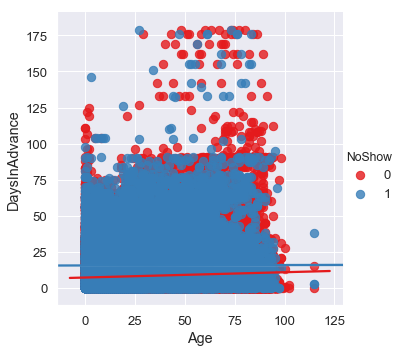

In [7]:
#plot
sns.lmplot('Age','DaysInAdvance', data=df, hue='NoShow', palette='Set1', fit_reg=True, scatter_kws={"s": 70})

In [8]:
# NOTE: calling describe when not all the data is categorical will cause the 
# categorical variables to be removed
df[['ScheduledDay','ScheduledTime','AppointmentDay',
    'Gender','age_range','Neighbourhood','Scholarship',
    'Hypertension','Diabetes','Alcoholism','Handicap',
    'SMSReceived','ScheduledDOW','AppointmentDOW','NoShow']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
NoShow,110527.0,0.201933,0.401444,0.0,0.0,0.0,0.0,1.0


#### One Hot Encode Variables

In [9]:
# perform one-hot encoding of the categorical data 
tmp_df = pd.get_dummies(df.Handicap,prefix='Handicap')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.AppointmentDOW,prefix='AppointmentDOW')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.ScheduledDOW,prefix='ScheduledDOW')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

#tmp_df = pd.get_dummies(df.Neighbourhood,prefix='Neighbourhood')
#df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df.age_range,prefix='age_range')
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

In [10]:
# replace the current Gender atribute with something slightly more intuitive and readable
df['IsMale'] = df.Gender=='male' 
df.IsMale = df.IsMale.astype(np.int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 38 columns):
Gender                      110527 non-null category
ScheduledDay                110527 non-null datetime64[ns]
ScheduledTime               110527 non-null object
AppointmentDay              110527 non-null datetime64[ns]
Age                         110527 non-null int64
Neighbourhood               110527 non-null category
Scholarship                 110527 non-null category
Hypertension                110527 non-null category
Diabetes                    110527 non-null category
Alcoholism                  110527 non-null category
Handicap                    110527 non-null category
SMSReceived                 110527 non-null category
NoShow                      110527 non-null int64
DaysInAdvance               110527 non-null int64
ScheduledDOW                110527 non-null object
AppointmentDOW              110527 non-null object
age_range                   106988 non-null 

#### Remove variables

In [11]:
# Now let's clean up the dataset
if 'Gender' in df:
    del df['Gender'] # if 'Sex' column still exists, delete it (as we created an ismale column)
    
if 'Handicap' in df:    
    del df['Handicap'] # get reid of the original category as it is now one-hot encoded
    
if 'ScheduledDOW' in df:    
    del df['ScheduledDOW'] # get reid of the original category as it is now one-hot encoded
    
if 'AppointmentDOW' in df:    
    del df['AppointmentDOW'] # get reid of the original category as it is now one-hot encoded

if 'Neighbourhood' in df:    
    del df['Neighbourhood'] # get reid of the original category as it is now one-hot encoded

#remove categorical variables for logistic regression analysis
if 'age_range' in df:
    del df['age_range']

if 'AppointmentID' in df:
    del df['AppointmentID']
    
if 'ScheduledDay' in df:
    del df['ScheduledDay']
    
if 'ScheduledTime' in df:
    del df['ScheduledTime']

if 'AppointmentDay' in df:
    del df['AppointmentDay']
    
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 29 columns):
Age                         110527 non-null int64
Scholarship                 110527 non-null category
Hypertension                110527 non-null category
Diabetes                    110527 non-null category
Alcoholism                  110527 non-null category
SMSReceived                 110527 non-null category
NoShow                      110527 non-null int64
DaysInAdvance               110527 non-null int64
Handicap_0                  110527 non-null uint8
Handicap_1                  110527 non-null uint8
Handicap_2                  110527 non-null uint8
Handicap_3                  110527 non-null uint8
Handicap_4                  110527 non-null uint8
AppointmentDOW_Friday       110527 non-null uint8
AppointmentDOW_Monday       110527 non-null uint8
AppointmentDOW_Saturday     110527 non-null uint8
AppointmentDOW_Thursday     110527 non-null uint8
AppointmentDOW_Tuesday  

In [12]:
df.head()

,Age,Scholarship,Hypertension,Diabetes,Alcoholism,SMSReceived,NoShow,DaysInAdvance,Handicap_0,Handicap_1,...,ScheduledDOW_Friday,ScheduledDOW_Monday,ScheduledDOW_Saturday,ScheduledDOW_Thursday,ScheduledDOW_Tuesday,ScheduledDOW_Wednesday,age_range_child,age_range_adult,age_range_senior,IsMale
0,62,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
1,56,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
2,62,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
3,8,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
4,56,0,1,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0


#### Logistic Regression Assumptions
<br>-Binary logistic regression requires the dependent variable to be binary.
<br>-For a binary regression, the factor level 1 of the dependent variable should represent the desired outcome.
<br>-Only the meaningful variables should be included.
<br>-The independent variables should be independent of each other. That is, the model should have little or no multicollinearity.
<br>-The independent variables are linearly related to the log odds.
<br>-Logistic regression requires quite large sample sizes.

ref: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [13]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

C:\Users\carol\AppData\Local\conda\conda\envs\MSDS7331\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
df['NoShow'].value_counts()

0    88208
1    22319
Name: NoShow, dtype: int64

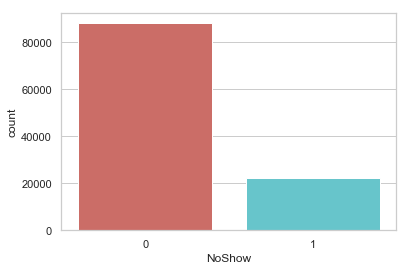

<Figure size 432x288 with 0 Axes>

In [15]:
sns.countplot(x='NoShow', data=df, palette='hls')
plt.show()
plt.savefig('count_plot')

In [18]:
count_NoShow = len(df[df['NoShow']==0])
count_Show = len(df[df['NoShow']==1])
pct_of_NoShow = count_NoShow/(count_NoShow+count_Show)
print("percentage of no shows are", pct_of_NoShow*100)
pct_of_Show = count_Show/(count_NoShow+count_Show)
print("percentage of shows", pct_of_Show*100)

percentage of no shows are 79.8067440534892
percentage of shows 20.193255946510806


Our classes are imbalanced, and the ratio of NoShows to Shows instances is 79:20.

In [19]:
df.groupby('NoShow').mean()

,Age,DaysInAdvance,Handicap_0,Handicap_1,Handicap_2,Handicap_3,Handicap_4,AppointmentDOW_Friday,AppointmentDOW_Monday,AppointmentDOW_Saturday,...,ScheduledDOW_Friday,ScheduledDOW_Monday,ScheduledDOW_Saturday,ScheduledDOW_Thursday,ScheduledDOW_Tuesday,ScheduledDOW_Wednesday,age_range_child,age_range_adult,age_range_senior,IsMale
NoShow,,,,,,,,,,,,,,,,,,,,,
0,37.790495,8.754659,0.979208,0.019001,0.001655,0.000113,0.000023,0.169849,0.204347,0.000340,...,0.170370,0.210004,0.000261,0.162944,0.236679,0.219742,0.196910,0.642844,0.127369,0
1,34.317667,15.831937,0.981764,0.016399,0.001658,0.000134,0.000045,0.180877,0.210135,0.000403,...,0.174157,0.204400,0.000045,0.165778,0.237107,0.218513,0.222322,0.656481,0.092567,0


#### Recursive Feature Elimination
Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

#### Creating Numpy Matrices

In [25]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'NoShow' in df:
    y = df['NoShow'].values # get the labels we want
    del df['NoShow'] # get rid of the class label
    X = df.values # use everything else to predict!

In [26]:
## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
#    have converted them into simple matrices to use with scikit learn
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, train_size=0.8)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=0.8)


In [35]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt


# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object
        #NOTE: as you increase C, test diff values by grid search
    #another par is balanced=TRUE/FALSE instead of class weight
    
# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration

# this does the exact same thing as the above block of code, but with shorter syntax

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.7959377544558038
confusion matrix
 [[17509   127]
 [ 4384    86]]
====Iteration 1  ====
accuracy 0.7887451370668597
confusion matrix
 [[17366   167]
 [ 4503    70]]
====Iteration 2  ====
accuracy 0.7971591423143038
confusion matrix
 [[17545   124]
 [ 4360    77]]


In [37]:
# and here is an even shorter way of getting the accuracies for each training and test set
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)

[0.79268072 0.79525921 0.79313309]


In [39]:
# here we can change some of the parameters interactively
from ipywidgets import widgets as wd

def lr_explor(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None) # get object
    accuracies = cross_val_score(lr_clf,X,y=y,cv=cv_object) # this also can help with parallelism
    print(accuracies)

wd.interact(lr_explor,cost=(0.001,5.0,0.05),__manual=True)

[0.79412829 0.79634488 0.79480684]


<function __main__.lr_explor(cost)>

## Interpretting weights

In [41]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])
    
# does this look correct? 

Age has weight of -0.013773442743991497
Scholarship has weight of 0.18147150235463033
Hypertension has weight of 0.035072729632570694
Diabetes has weight of 0.13726976901381865
Alcoholism has weight of 0.1833313934242121
SMSReceived has weight of 0.3651110501804255
DaysInAdvance has weight of 0.022828162852682174
Handicap_0 has weight of -0.3933569696038911
Handicap_1 has weight of -0.3634754513096032
Handicap_2 has weight of -0.2606354959621638
Handicap_3 has weight of -0.005935239454372811
Handicap_4 has weight of -0.08751562728386394
AppointmentDOW_Friday has weight of -0.20149395264174097
AppointmentDOW_Monday has weight of -0.2643870581424524
AppointmentDOW_Saturday has weight of 0.3518353816071514
AppointmentDOW_Thursday has weight of -0.3354578023949101
AppointmentDOW_Tuesday has weight of -0.32965946892101006
AppointmentDOW_Wednesday has weight of -0.33175588305968184
ScheduledDOW_Friday has weight of -0.15246508035285977
ScheduledDOW_Monday has weight of -0.1379956089643427
Sc

In [43]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

C:\Users\carol\AppData\Local\conda\conda\envs\MSDS7331\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\carol\AppData\Local\conda\conda\envs\MSDS7331\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\carol\AppData\Local\conda\conda\envs\MSDS7331\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


accuracy: 0.7952592056455261
[[17514   153]
 [ 4373    66]]
Age has weight of -0.31540187859755897
AppointmentDOW_Wednesday has weight of -0.016127025187530175
ScheduledDOW_Saturday has weight of -0.015594937398951774
ScheduledDOW_Friday has weight of -0.014767449865036671
AppointmentDOW_Thursday has weight of -0.014577873322193942
AppointmentDOW_Tuesday has weight of -0.010134581810060035
Handicap_0 has weight of -0.004281551889880925
ScheduledDOW_Tuesday has weight of -0.0014128167768018844
IsMale has weight of 0.0
Handicap_1 has weight of 0.0007870063319144567
ScheduledDOW_Monday has weight of 0.0007987954146620982
ScheduledDOW_Wednesday has weight of 0.006348228586581786
Handicap_2 has weight of 0.007404726953631684
AppointmentDOW_Monday has weight of 0.008217438461071112
Hypertension has weight of 0.008587430180199827
ScheduledDOW_Thursday has weight of 0.009228497249319415
Handicap_3 has weight of 0.011193412301022032
AppointmentDOW_Saturday has weight of 0.01572007317049345
Hand

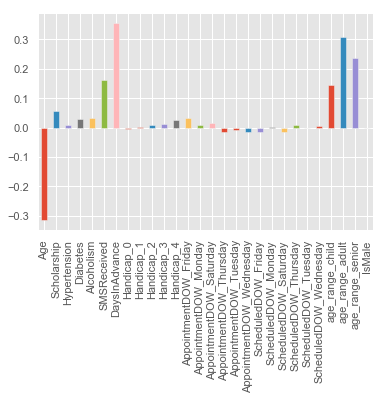

In [45]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=df.columns)
weights.plot(kind='bar')
plt.show()

### Cross Validation
Cross validation is performed using repeated holdout via ShuffleSplit()

Ten folds are used
The split is: 80% training data and 20% test data
A random seed is set so the same random test and training splits are used each time cross validation is performed.

In [36]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=4, test_size=0.20, random_state=0)

### Classifier Evaluation
The following functions performs cross validation using cross_validate() for classification estimators and returns accuracy, precision, recall, f1 score, and a confusion matrix for each model.

In [29]:
from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X, y, scoring=['accuracy','precision','recall']
                            , cv=cv_object, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X, y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(y,predictions)
    confMat = confusion_matrix(y,predictions)
    acc = accuracy_score(y,predictions)
    
    print(classReport)
    print(confMat)
    print(acc)

In [30]:
#Logisitic regression 5-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_object # KFolds = 5
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   59.3s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:  2.4min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=0.8),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced', 'none'], 'random_state': [0], 'solver': ['lbfgs'], 'max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [31]:
#Diplay the top model parameters
regGridSearch.best_estimator_

LogisticRegression(C=100, class_weight='none', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X, y, cv_object)

The average accuracy for all cv folds is: 			 0.79494
The average precision for all cv folds is: 			 0.32239
The average recall for all cv folds is: 			 0.017156
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.794581,0.292576,0.015070
1,0.795123,0.333333,0.017067
2,0.795123,0.341270,0.019330


In [33]:
EvaluateClassifierEstimator2(classifierEst, X, y, 10)

             precision    recall  f1-score   support

          0       0.80      0.99      0.88     88208
          1       0.28      0.02      0.03     22319

avg / total       0.69      0.79      0.71    110527

[[87319   889]
 [21981   338]]
0.7930822333004606


In [ ]:
#sort

### Start of another model